In [23]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Funciones Auxiliares

In [74]:
def preprocesar(archivos):
  paquetes_procesados = []

  for archivo in archivos:
    with open(archivo) as f:
      paquetes = json.load(f)

      for paquete in paquetes:
        layers = paquete['_source']['layers']
        frame_time = float(layers['frame']['frame.time_relative'])
        eth_dst = layers['eth']['eth.dst']
        eth_src = layers['eth']['eth.src']

        paquete = {
          'time_relative': frame_time,
          'eth.dst': eth_dst,
          'eth.src': eth_src
        }

        paquetes_procesados.append(paquete)

  df = pd.DataFrame(paquetes_procesados)

  return df

In [146]:
def preprocesar_icmp(archivos):
  paquetes_icmp = []

  for archivo in archivos:
    with open(archivo) as f:
      paquetes = json.load(f)

      for paquete in paquetes:
        layers = paquete['_source']['layers']

        if 'icmp'  in layers:
          paquete = {
            'frame.time_relative': float(layers['frame']['frame.time_relative']),
            'frame.len': int(layers['frame']['frame.len']),
            'icmp.type': int(layers['icmp']['icmp.type']),
            'icmp.ident': int(layers['icmp']['icmp.ident']),
            'icmp.seq': int(layers['icmp']['icmp.seq'])
          }

          paquetes_icmp.append(paquete)

  df = pd.DataFrame(paquetes_icmp)

  return df

In [33]:
def identificar_paquetes_no_dirigidos(df, mac_host):
    df_recibidos = df[df['eth.src'] != mac_host].copy()

    df_recibidos['no_dirigido'] = df_recibidos['eth.dst'] != mac_host
    return df_recibidos

In [7]:
def contabilizar_paquetes_no_dirigidos(df, intervalo_tiempo=0.5):
    df['time_window'] = np.floor(df['time_relative'] / intervalo_tiempo)

    paquetes_no_dirigidos = df[df['no_dirigido']].groupby('time_window').size()

    tiempo_max = df['time_window'].max()
    todas_las_ventanas = pd.Series(0, index=np.arange(0, tiempo_max + 1))
    paquetes_no_dirigidos = todas_las_ventanas.add(paquetes_no_dirigidos, fill_value=0)

    return paquetes_no_dirigidos

In [120]:
def procesar_escenario_multiple_hosts(directorio_base, mac_hosts):
    paquetes_no_dirigidos_hosts = []

    for i, mac_host in enumerate(mac_hosts):
        archivo = directorio_base + f'device_{i}.json'

        df = preprocesar([archivo])
        df = identificar_paquetes_no_dirigidos(df, mac_host)
        paquetes_no_dirigidos = contabilizar_paquetes_no_dirigidos(df)
        paquetes_no_dirigidos_hosts.append(paquetes_no_dirigidos)
 
    if paquetes_no_dirigidos_hosts:
        df_concatenado = pd.concat(paquetes_no_dirigidos_hosts, axis=1).fillna(0)
        promedio_paquetes_no_dirigidos = df_concatenado.mean(axis=1)
    else:
        promedio_paquetes_no_dirigidos = pd.Series()

    return promedio_paquetes_no_dirigidos

In [147]:
def recortar_dataFrame(df, tiempo_inicio=0, tiempo_final=1000):
  return df.loc[(df['frame.time_relative'] >= tiempo_inicio) & (df['frame.time_relative'] <= tiempo_final)].copy()

In [179]:
def calcular_perdida(df, intervalo_tiempo=1.0):
    df['frame.time_relative'] = df['frame.time_relative'].astype(float)
    df['icmp.type'] = df['icmp.type'].astype(int)
    df['icmp.ident'] = df['icmp.ident'].astype(int)
    df['icmp.seq'] = df['icmp.seq'].astype(int)

    df['time_window'] = np.floor(df['frame.time_relative'] / intervalo_tiempo)

    requests = df[df['icmp.type'] == 8].copy()  # Echo Request
    replies = df[df['icmp.type'] == 0].copy()   # Echo Reply

    requests['time_window'] = np.floor(requests['frame.time_relative'] / intervalo_tiempo)
    replies['time_window'] = np.floor(replies['frame.time_relative'] / intervalo_tiempo)

    conteo_requests = requests.groupby('time_window').size()
    conteo_replies = replies.groupby('time_window').size()

    ventanas = pd.Index(np.arange(int(df['time_window'].min()), int(df['time_window'].max()) + 1))
    conteo_requests = conteo_requests.reindex(ventanas, fill_value=0)
    conteo_replies = conteo_replies.reindex(ventanas, fill_value=0)

    paquetes_perdidos_por_ventana = conteo_requests - conteo_replies
    paquetes_perdidos_por_ventana[paquetes_perdidos_por_ventana < 0] = 0  # Asegurar que no haya valores negativos

    porcentaje_perdida_por_ventana = (paquetes_perdidos_por_ventana / conteo_requests.replace(0, np.nan)) * 100
    porcentaje_perdida_por_ventana = porcentaje_perdida_por_ventana.fillna(0)  # Reemplazar NaN por 0 donde no hubo requests

    return paquetes_perdidos_por_ventana

In [173]:
def calcular_latencia_ms(df, intervalo_tiempo=1.0):
    df['frame.time_relative'] = df['frame.time_relative'].astype(float)
    df['icmp.type'] = df['icmp.type'].astype(int)
    df['icmp.ident'] = df['icmp.ident'].astype(int)
    df['icmp.seq'] = df['icmp.seq'].astype(int)

    requests = df[df['icmp.type'] == 8]
    replies = df[df['icmp.type'] == 0]

    merged = pd.merge(
        requests,
        replies,
        on=['icmp.ident', 'icmp.seq'],
        suffixes=('_req', '_rep')
    )

    merged['latencia_ms'] = (merged['frame.time_relative_rep'] - merged['frame.time_relative_req']) * 1000  # Convertir a ms

    merged['time_window'] = np.floor(merged['frame.time_relative_req'] / intervalo_tiempo)

    latencia_por_ventana = merged.groupby('time_window')['latencia_ms'].mean()

    return latencia_por_ventana

In [138]:
def calcular_rendimiento_bps(df, intervalo_tiempo=1.0):
    df['frame.time_relative'] = df['frame.time_relative'].astype(float)
    df['frame.len'] = df['frame.len'].astype(float)

    df['time_window'] = np.floor(df['frame.time_relative'] / intervalo_tiempo)

    throughput_por_ventana = df.groupby('time_window')['frame.len'].sum()
    throughput_por_ventana /= intervalo_tiempo

    return throughput_por_ventana

## Funciones para combinar los datos de las 2 comunicaciones

In [140]:
def combinar_paquetes_perdidos(lista_dfs, intervalo_tiempo=0.5):
    perdidas_por_comunicacion = [calcular_perdida(df, intervalo_tiempo) for df in lista_dfs]

    perdida_total = perdidas_por_comunicacion[0]
    for perdidas in perdidas_por_comunicacion[1:]:
        perdida_total = perdida_total.add(perdidas, fill_value=0)

    return perdida_total

In [162]:
def promediar_metricas(lista_dfs, calcular_metrica, intervalo_tiempo=0.5):
    metricas_por_comunicacion = [calcular_metrica(df, intervalo_tiempo=intervalo_tiempo) for df in lista_dfs]

    metrica_total = metricas_por_comunicacion[0]
    for metrica in metricas_por_comunicacion[1:]:
        metrica_total += metrica
 
    metrica_promedio = metrica_total / len(metricas_por_comunicacion)

    return metrica_promedio

# Datos

In [122]:
dir_base = "/home/emanuel/Documents/redes/parcial2/segundoPunto/datosYo/"

In [129]:
escenarios = {
    'Hubs': 'hubCongestion/',
    'Switches': 'switchSinCongestion/',
}

mac_hosts = [
    "00:00:00:00:00:02",
    "00:00:00:00:00:04",
    "00:00:00:00:00:06",
    "00:00:00:00:00:08",
    "00:00:00:00:00:0a",
    "00:00:00:00:00:0c"
]

resultados_promedio = {}
for etiqueta, directorio_base in escenarios.items():
    promedio_paquetes = procesar_escenario_multiple_hosts(dir_base + directorio_base, mac_hosts)
    resultados_promedio[etiqueta] = promedio_paquetes

In [154]:
dirs = ["hubCongestion/", "hubSinCongestion/", "switchCongestion/", "switchSinCongestion/"]
data_frames = []

for d in dirs:
  comunicacion1 = preprocesar_icmp([dir_base + d + "device_0.json"])
  comunicacion2 = preprocesar_icmp([dir_base + d + "device_1.json"])
  comunicacion3 = preprocesar_icmp([dir_base + d + "device_2.json"])

  data_frames.append((comunicacion1, comunicacion2, comunicacion3))

# Gráficas

## Funciones para graficar

In [131]:
def graficar_resultados_promedio(resultados, intervalo_tiempo=0.5):
    plt.figure(figsize=(10, 6))
    for etiqueta, datos in resultados.items():
        plt.plot(datos.index * intervalo_tiempo, datos.values, marker='o', label=etiqueta)
    plt.title('Promedio de paquetes no dirigidos recibidos por host')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Promedio de paquetes no dirigidos')
    plt.legend()
    plt.grid(True)
    plt.show()

## Switches vs Hubs

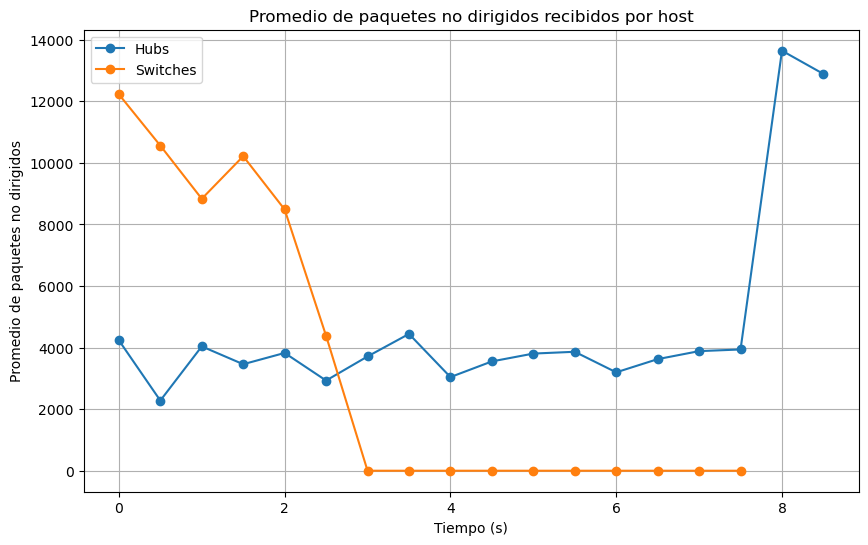

In [132]:
graficar_resultados_promedio(resultados_promedio)

# Métricas obtenidas

In [149]:
def obtenerEstadisticasSerie(data_frames):
    estadisticas = []

    for df in data_frames:
        estadisticasSerie = {
            "promedio": np.mean(df),
            "desviacion_estandar": np.std(df)
        }

        estadisticas.append(estadisticasSerie)

    return estadisticas

In [181]:
def graficarEstadisticasSerie(estadisticas_serie, titulo, nombre_metrica, nombres):
  promedios = [estadisticas["promedio"] for estadisticas in estadisticas_serie]
  desviaciones = [estadisticas["desviacion_estandar"] for estadisticas in estadisticas_serie]

  f, ax = plt.subplots(figsize=(10, 5))
  ax.bar(nombres, promedios)
  ax.set_title(titulo)
  ax.set_ylabel(nombre_metrica)
  ax.grid(True)

  return ax

## Latencia

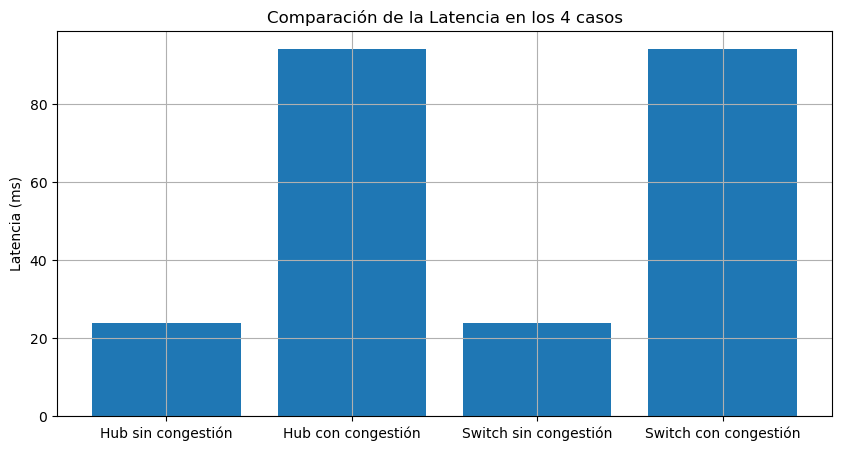

In [182]:
data_frames2 = []

tiempo_final=200
for df in data_frames:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=tiempo_final)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=tiempo_final)
  df_filtrado2 = recortar_dataFrame(df[2], tiempo_final=tiempo_final)
  df_combinado = promediar_metricas([df_filtrado0, df_filtrado1, df_filtrado2], calcular_latencia_ms)
  data_frames2.append(df_combinado)

estadisticasLatencia = obtenerEstadisticasSerie(data_frames2)
ax = graficarEstadisticasSerie(estadisticasLatencia,
 "Comparación de la Latencia en los 4 casos",
  "Latencia (ms)", ["Hub sin congestión", "Hub con congestión", "Switch sin congestión", "Switch con congestión"])

## Rendimiento

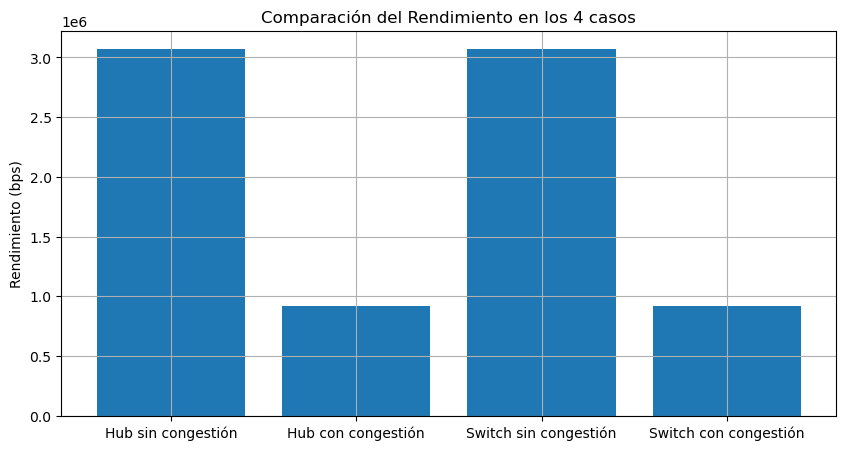

In [183]:
data_frames2 = []

tiempo_final=200
for df in data_frames:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=tiempo_final)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=tiempo_final)
  df_filtrado2 = recortar_dataFrame(df[2], tiempo_final=tiempo_final)
  df_combinado = promediar_metricas([df_filtrado0, df_filtrado1, df_filtrado2], calcular_rendimiento_bps)
  data_frames2.append(df_combinado)

estadisticasLatencia = obtenerEstadisticasSerie(data_frames2)
ax = graficarEstadisticasSerie(estadisticasLatencia,
 "Comparación del Rendimiento en los 4 casos",
  "Rendimiento (bps)", ["Hub sin congestión", "Hub con congestión", "Switch sin congestión", "Switch con congestión"])

## Pérdida de paquetes

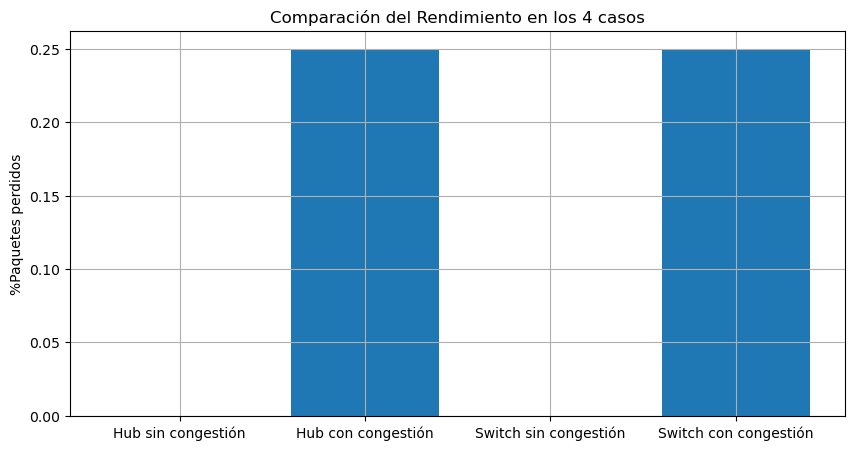

In [185]:
data_frames2 = []

tiempo_final=200
for df in data_frames:
  df_filtrado0 = recortar_dataFrame(df[0], tiempo_final=tiempo_final)
  df_filtrado1 = recortar_dataFrame(df[1], tiempo_final=tiempo_final)
  df_filtrado2 = recortar_dataFrame(df[2], tiempo_final=tiempo_final)
  df_combinado = combinar_paquetes_perdidos([df_filtrado0, df_filtrado1, df_filtrado2])
  data_frames2.append(df_combinado)

estadisticasLatencia = obtenerEstadisticasSerie(data_frames2)
ax = graficarEstadisticasSerie(estadisticasLatencia,
 "Comparación del Rendimiento en los 4 casos",
  "%Paquetes perdidos", ["Hub sin congestión", "Hub con congestión", "Switch sin congestión", "Switch con congestión"])